In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
42433,NaN,NaN,International,2020-09-06,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42434,NaN,NaN,International,2020-09-07,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42435,NaN,NaN,International,2020-09-08,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


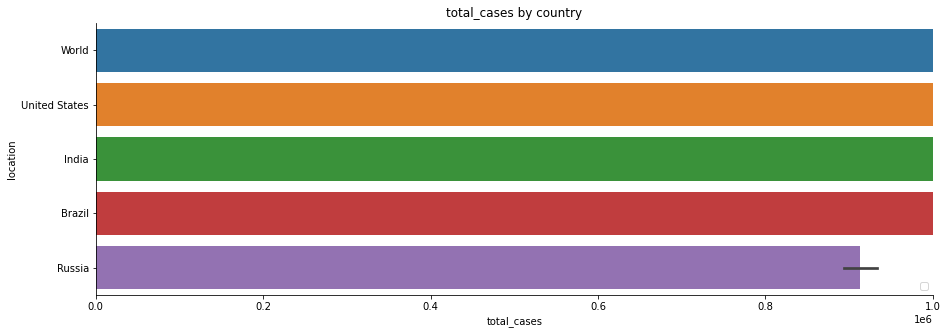

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


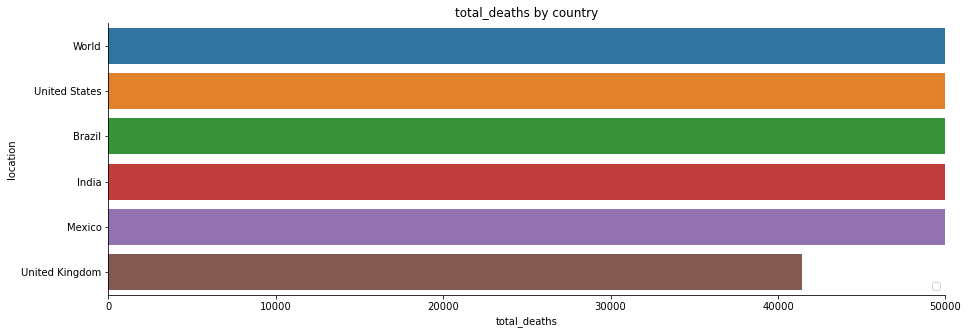

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


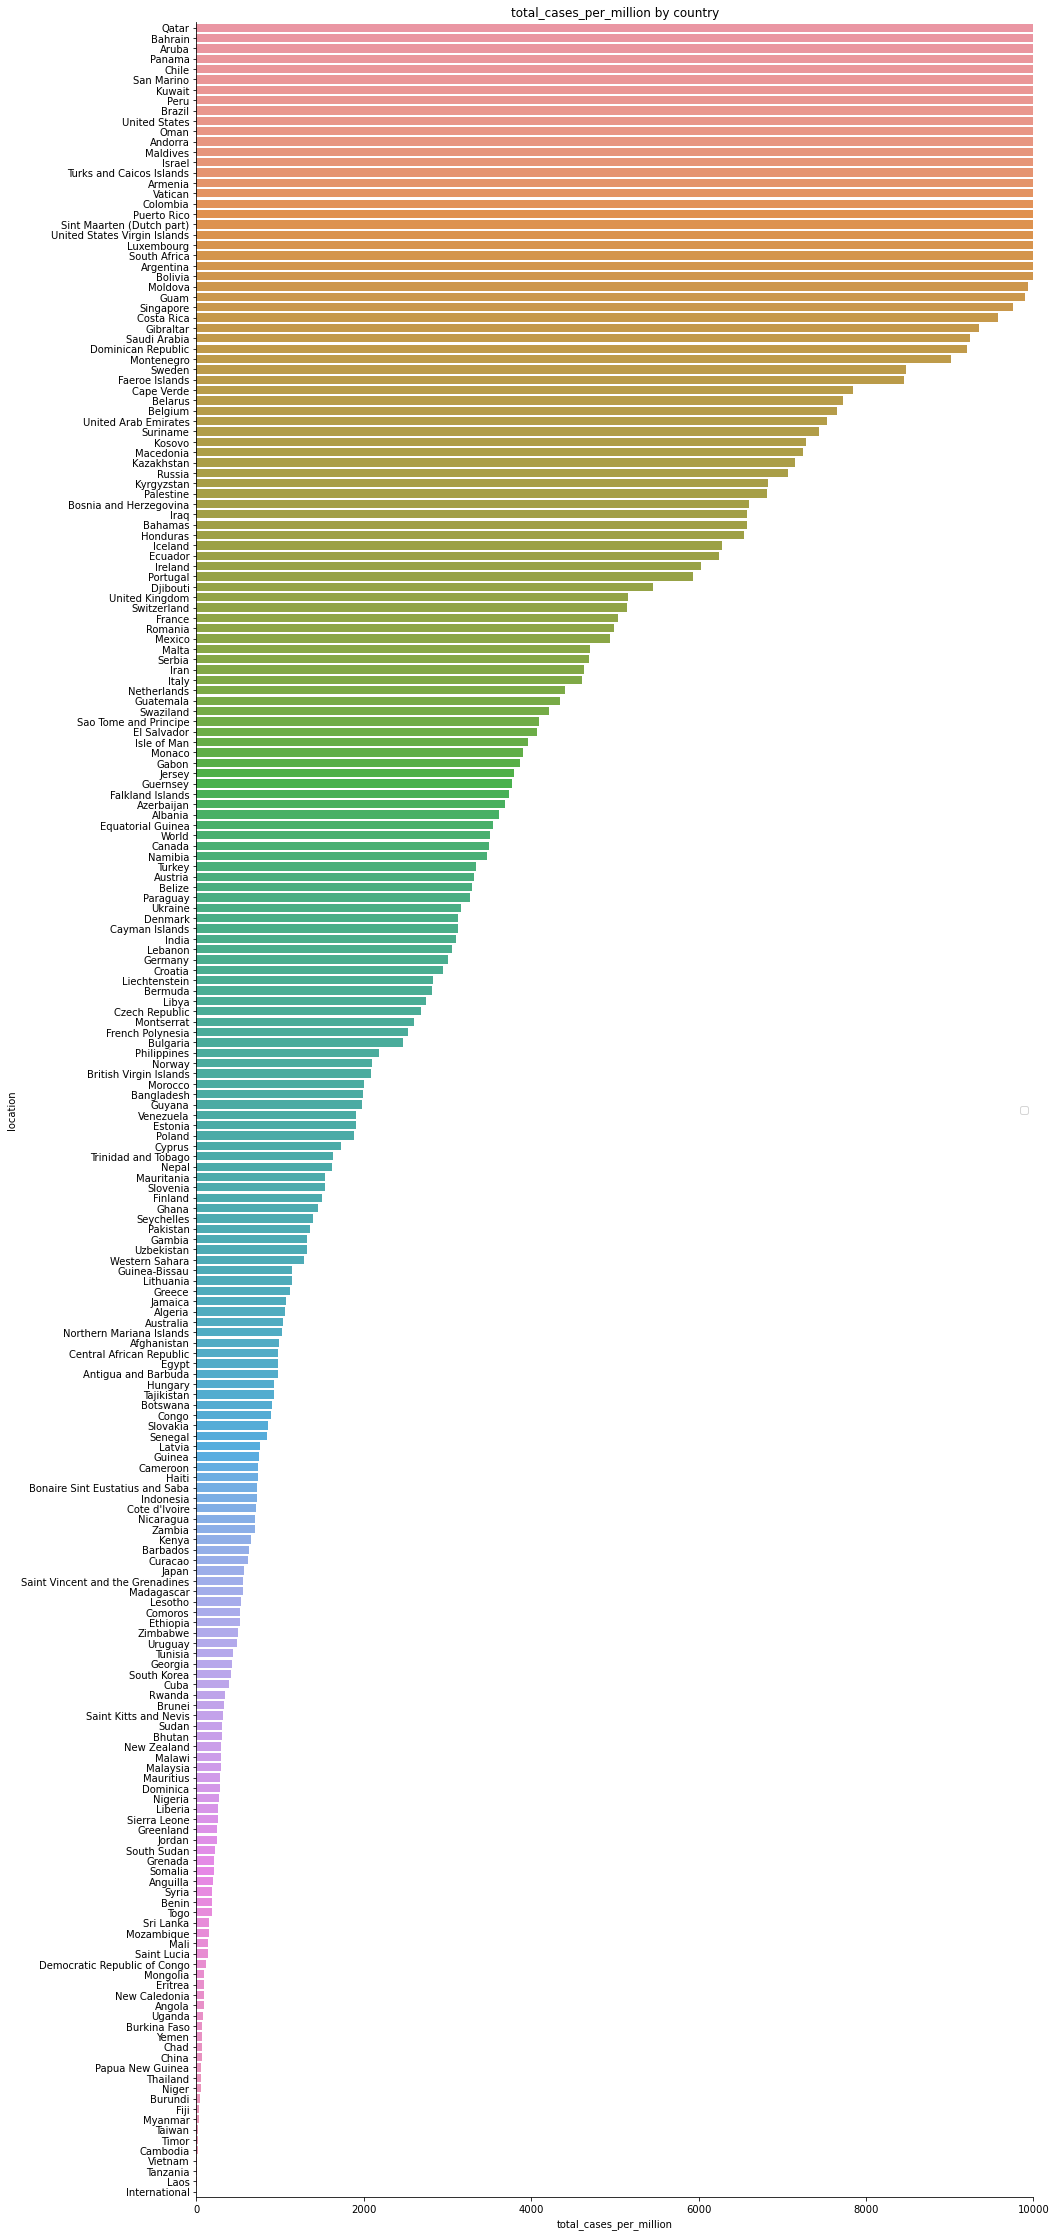

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


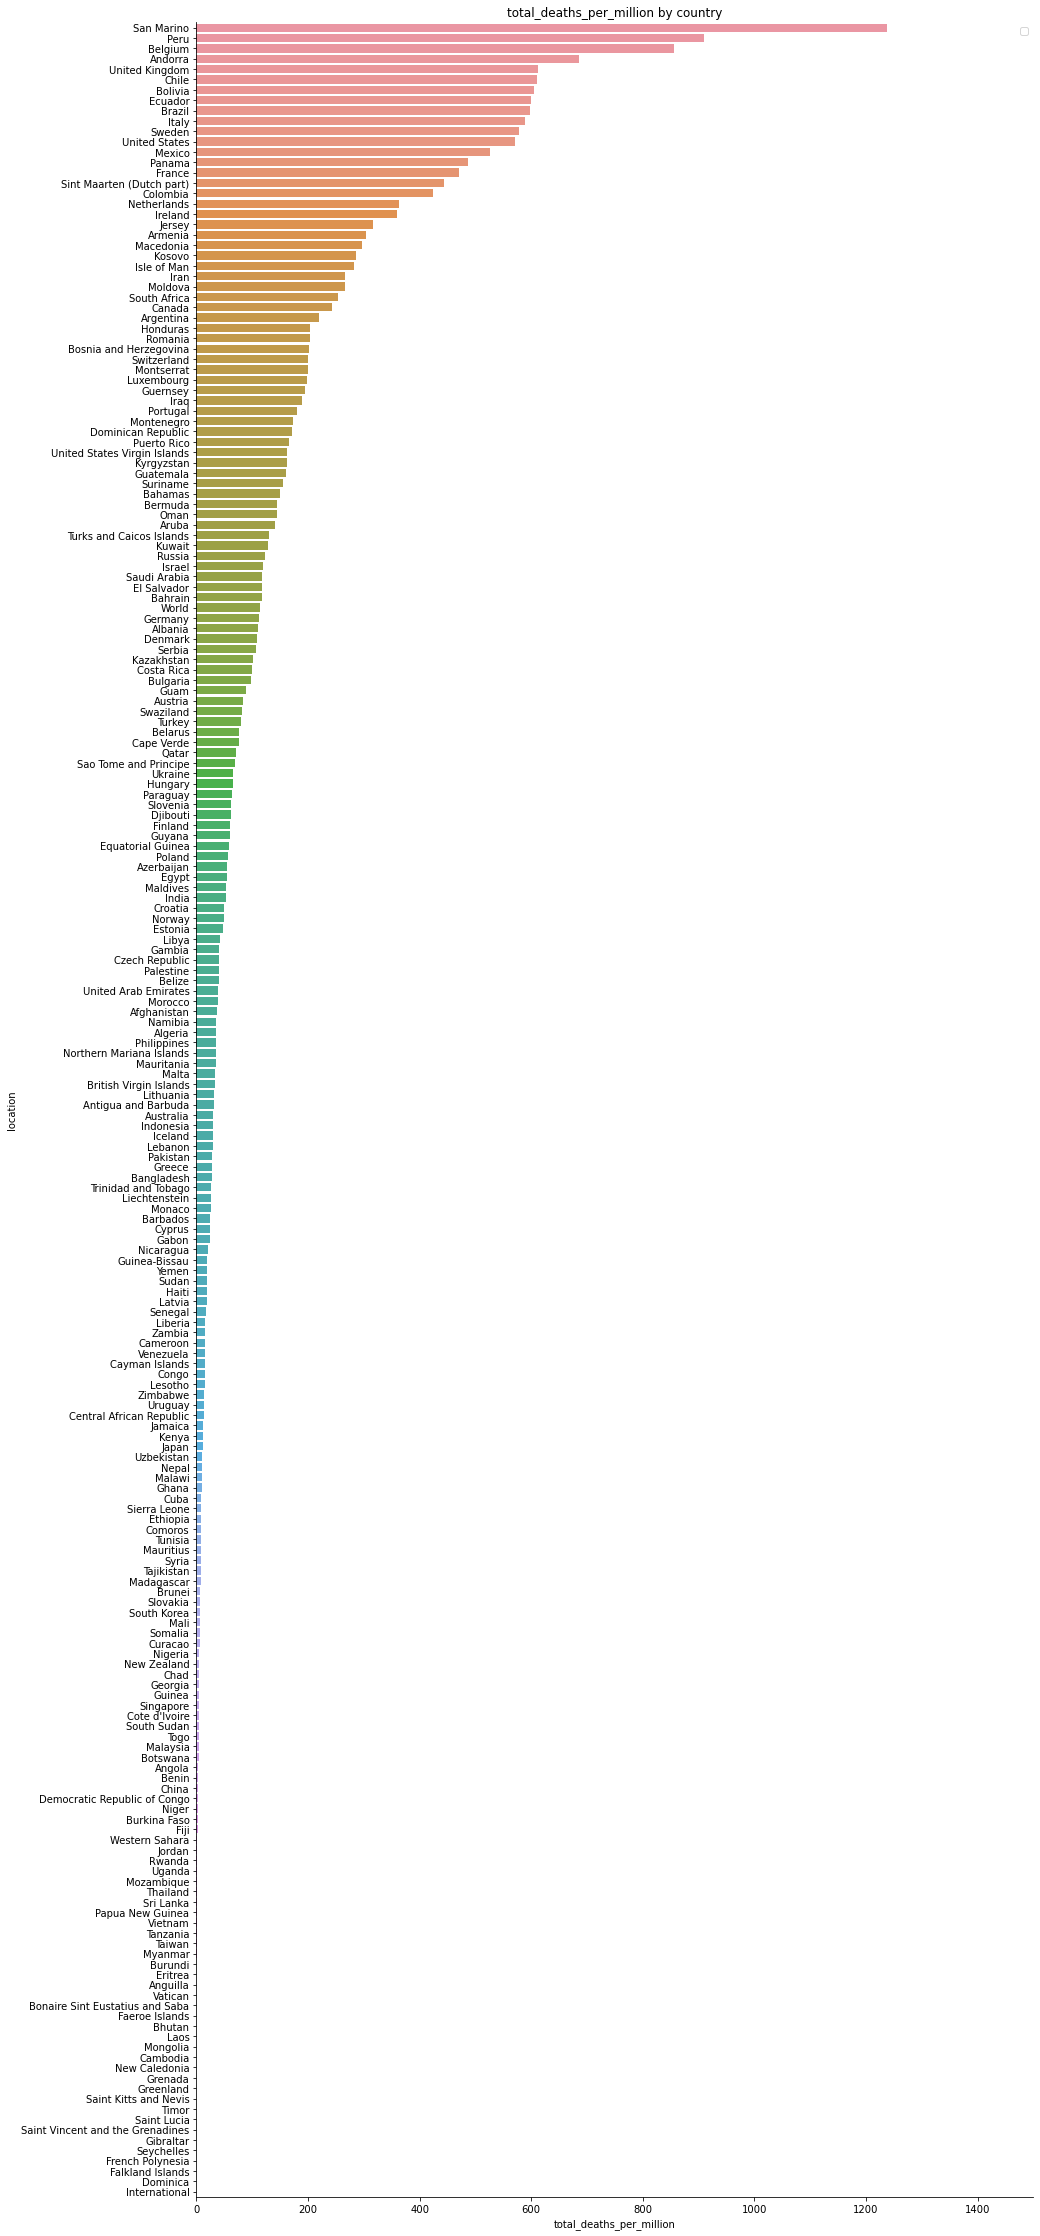

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

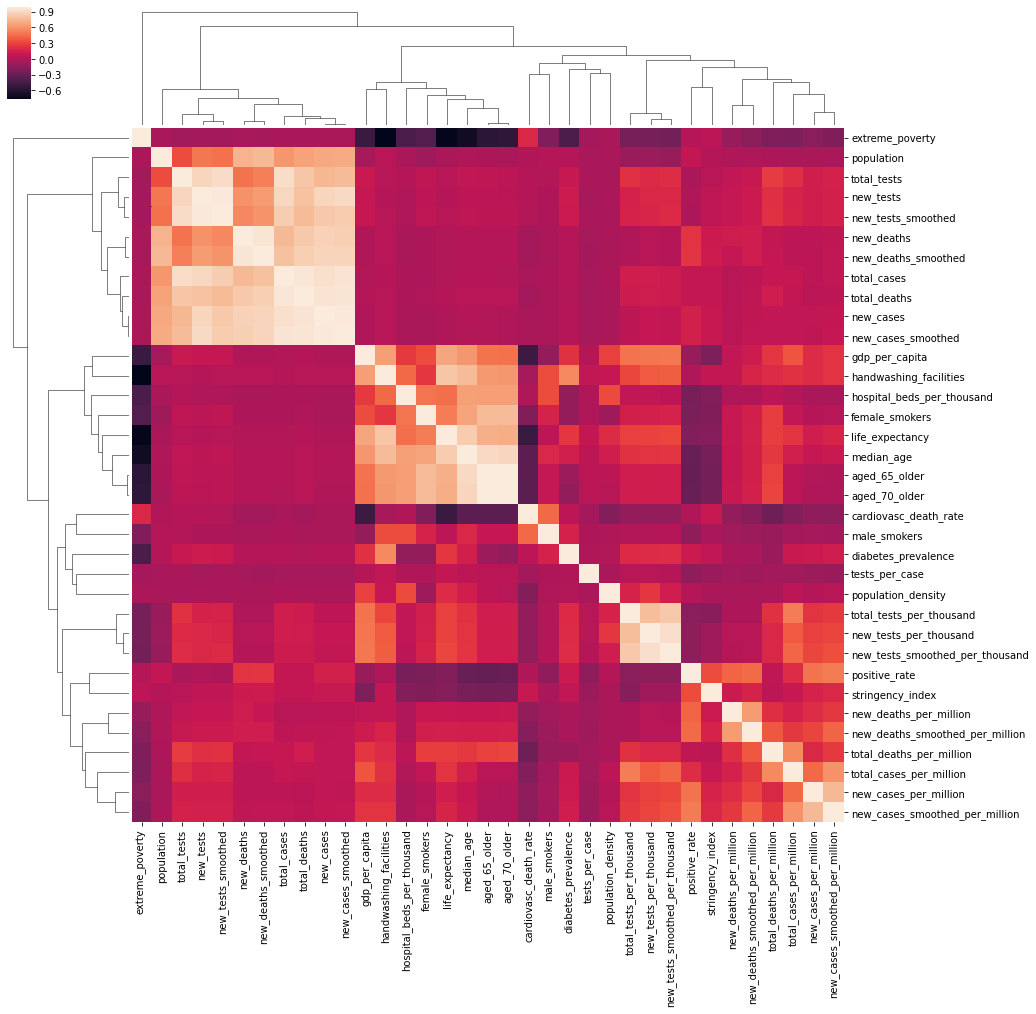

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999136049528167 (+/- 0.0009266631965716917)
Coef :  [1.03504380e+00 8.90892207e-05 9.33091938e-05]
3 Last_days :  [[26921192 27169672 27366648]]
Today :  27366648
Prediction + :  593503
Tomorow :  27960151
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996342600418909 (+/- 0.00010544308681339832)
Coef :  [0.11606416 0.43507143 0.45922081]
3 Last_days :  [[880311 889339 893084]]
Today :  893084
Prediction + :  8981
Tomorow :  902065
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.874526998572461 (+/- 0.17145137205185534)
Coef :  [-0.73180784  0.77164846  0.96315194]
3 Last_days :  [[317706 324777 328980]]
Today :  328980
Prediction + :  6109
Tomorow :  335089
                                     
--------- Total Death -----------------
                                     
R^2: 0.8116295544584573 (+/- 0.25594683253022843)
Coef :  [-0.75057634  0.78870064  0.96086867]
3 Last_days :  [[30698 30701 30726]]
Today :  30726
Prediction + :  23
Tomorow :  30749
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9383693660763281 (+/- 0.05003922721815164)
Coef :  [-0.32674966 -0.01608094  1.33709758]
3 Last_days :  [[90025 90058 90079]]
Today :  90079
Prediction + :  29
Tomorow :  90108
                                     
--------- Total Death -----------------
                                     
R^2: -117.44832120154918 (+/- 167.39481912624436)
Coef :  [-0.07721588  0.01245587  1.05659882]
3 Last_days :  [[4728 4730 4732]]
Today :  4732
Prediction + :  6
Tomorow :  4738
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.956289363983048 (+/- 0.060771604346916225)
Coef :  [-0.8222681   0.89736402  0.92422798]
3 Last_days :  [[276338 277634 278784]]
Today :  278784
Prediction + :  1181
Tomorow :  279965
                                     
--------- Total Death -----------------
                                     
R^2: 0.6676714370494494 (+/- 0.44431511830206954)
Coef :  [-0.8256997   0.89818606  0.92658721]
3 Last_days :  [[35534 35541 35553]]
Today :  35553
Prediction + :  26
Tomorow :  35579
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9718276493128775 (+/- 0.029888738219728973)
Coef :  [-0.428908    0.29012673  1.1432977 ]
3 Last_days :  [[498989 498989 525549]]
Today :  525549
Prediction + :  6255
Tomorow :  531804
                                     
--------- Total Death -----------------
                                     
R^2: 0.03186053020170554 (+/- 1.1022353671494016)
Coef :  [-0.7269624   0.63160567  1.09435936]
3 Last_days :  [[29418 29418 29516]]
Today :  29516
Prediction + :  18
Tomorow :  29534
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9783752051730975 (+/- 0.03008657917319254)
Coef :  [0.08811996 0.45725467 0.46908448]
3 Last_days :  [[6245866 6276421 6300671]]
Today :  6300671
Prediction + :  90519
Tomorow :  6391190
                                     
--------- Total Death -----------------
                                     
R^2: 0.996296154184512 (+/- 0.0036912683736490203)
Coef :  [-0.48916741  0.70853813  0.78323892]
3 Last_days :  [[188538 188941 189208]]
Today :  189208
Prediction + :  999
Tomorow :  190207
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9231584060992811 (+/- 0.10784591940818158)
Coef :  [-0.70745775  0.8410042   0.86682507]
3 Last_days :  [[344164 347152 350100]]
Today :  350100
Prediction + :  2403
Tomorow :  352503
                                     
--------- Total Death -----------------
                                     
R^2: 0.32517183330512833 (+/- 0.9119391015453719)
Coef :  [-0.76942128  0.83130539  0.93745405]
3 Last_days :  [[41549 41551 41554]]
Today :  41554
Prediction + :  36
Tomorow :  41590
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8833708879209187 (+/- 0.16366358252055427)
Coef :  [-0.78987986  0.85418778  0.93541797]
3 Last_days :  [[249985 250799 252298]]
Today :  252298
Prediction + :  794
Tomorow :  253092
                                     
--------- Total Death -----------------
                                     
R^2: 0.33447805257212965 (+/- 0.9304270042002027)
Coef :  [-0.78892879  0.84044408  0.94775518]
3 Last_days :  [[9325 9325 9329]]
Today :  9329
Prediction + :  6
Tomorow :  9335
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -5.826468118059496 (+/- 9.652377943324318)
Coef :  [0.24704571 0.38264897 0.38115939]
3 Last_days :  [[384666 386658 388810]]
Today :  388810
Prediction + :  3830
Tomorow :  392640
                                     
--------- Total Death -----------------
                                     
R^2: 0.9624665909139914 (+/- 0.052494871020138806)
Coef :  [0.03664412 0.49210504 0.48242326]
3 Last_days :  [[22154 22293 22410]]
Today :  22410
Prediction + :  241
Tomorow :  22651
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9985397550153264 (+/- 0.001755251833606845)
Coef :  [-0.70541102  0.8343906   0.86840627]
3 Last_days :  [[278228 279806 281509]]
Today :  281509
Prediction + :  1266
Tomorow :  282775
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990538938766096 (+/- 0.000781053808390039)
Coef :  [-0.81182112  0.89313366  0.91621509]
3 Last_days :  [[6620 6673 6730]]
Today :  6730
Prediction + :  42
Tomorow :  6772
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.603957266985951 (+/- 0.5554917064960223)
Coef :  [-0.11524942  0.48798123  0.64228175]
3 Last_days :  [[4123000 4137521 4147794]]
Today :  4147794
Prediction + :  67341
Tomorow :  4215135
                                     
--------- Total Death -----------------
                                     
R^2: 0.4762156694026472 (+/- 0.7358676180006429)
Coef :  [-0.08834073  0.50659943  0.59327605]
3 Last_days :  [[126203 126650 126960]]
Today :  126960
Prediction + :  1662
Tomorow :  128622
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(27366648, 893084, 27960151, 902065),
 (328980, 30726, 335089, 30749),
 (278784, 35553, 279965, 35579),
 (525549, 29516, 531804, 29534),
 (6300671, 189208, 6391190, 190207),
 (90079, 4732, 90108, 4738),
 (350100, 41554, 352503, 41590),
 (252298, 9329, 253092, 9335),
 (388810, 22410, 392640, 22651),
 (281509, 6730, 282775, 6772),
 (4147794, 126960, 4215135, 128622)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-08,France,335089.0,0.0,30749.0,0.0,0.0,0.0
0,2020-09-08,China,90108.0,0.0,4738.0,0.0,0.0,0.0
0,2020-09-08,Italy,279965.0,0.0,35579.0,0.0,0.0,0.0
0,2020-09-08,Spain,531804.0,0.0,29534.0,0.0,0.0,0.0
0,2020-09-08,United States,6391190.0,0.0,190207.0,0.0,0.0,0.0
0,2020-09-08,World,27960151.0,0.0,902065.0,0.0,0.0,0.0
0,2020-09-08,United Kingdom,352503.0,0.0,41590.0,0.0,0.0,0.0
0,2020-09-08,Germany,253092.0,0.0,9335.0,0.0,0.0,0.0
0,2020-09-08,Iran,392640.0,0.0,22651.0,0.0,0.0,0.0
0,2020-09-08,Turkey,282775.0,0.0,6772.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")